In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the mapping from mapping.txt
def load_mapping(mapping_file):
    mapping = {}
    with open(mapping_file, 'r') as f:
        for line in f:
            key, value = line.strip().split()
            mapping[int(key)] = chr(int(value))
    return mapping

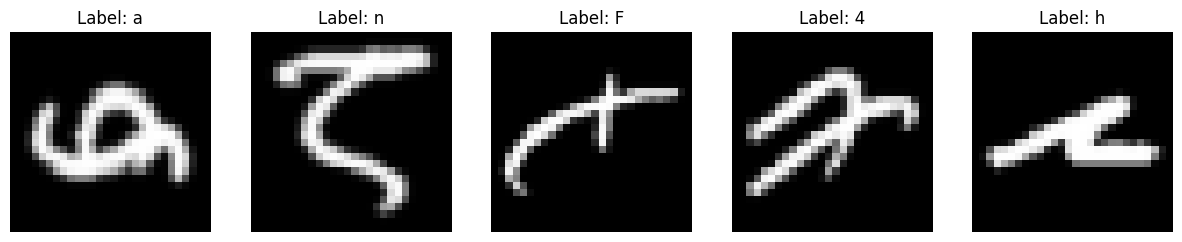

In [ ]:
import matplotlib.pyplot as plt
# Display the first few images along with their ASCII labels
def show_images(dataset, mapping, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.numpy().squeeze()
        ascii_label = mapping[label]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {ascii_label}')
        axes[i].axis('off')
    plt.show()

show_images(dataset, mapping=mapping, num_images=5)

In [ ]:
import os

class CharacterDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.labels = self.data.iloc[:, 0].values
        self.images = self.data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32')
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:


PATH='drive/MyDrive/Subjectivity'

test_csv_file = os.path.join(PATH, 'data', 'characters-test.csv')
test_dataset = CharacterDataset(test_csv_file, transform=transform)

# Create DataLoader for testing
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


NameError: name 'batch_size' is not defined

In [ ]:

# # Evaluate the model on the test dataset
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_dataloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 75.4029469652641%


In [ ]:
device

device(type='cpu')

In [4]:

import os

class CharacterDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.labels = self.data.iloc[:, 0].values
        self.images = self.data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32')
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert single-channel to three channels
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
import os

PATH='drive/MyDrive/Subjectivity'

# Load the dataset
csv_file = os.path.join(PATH, 'data', 'characters.csv')
train_dataset = CharacterDataset(csv_file, transform=transform)

In [6]:

test_csv_file = os.path.join(PATH, 'data', 'characters-test.csv')

test_dataset = CharacterDataset(test_csv_file, transform=transform)

In [7]:
mapping_file = os.path.join(PATH, 'data', 'mapping.txt')
mapping = load_mapping(mapping_file)

In [8]:

# Function to create the model
def create_model():
    model = models.resnet18(pretrained=True)

    # Move the model to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print(device)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(mapping))

    # Freeze all layers except the last three
    for name, param in model.named_parameters():
        if "layer4" not in name and "fc" not in name:
            param.requires_grad = False

    return model

# Function to train the model
def train_model(model, train_dataloader, learning_rate, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}')

    return model

# Function to save the model
def save_model(model, learning_rate, batch_size):
    model_path = f'resnet18_finetuned_lr{learning_rate}_bs{batch_size}.pth'
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

# Function to evaluate the model
def evaluate_model(model, test_dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')
    return accuracy



In [ ]:
# Experiment with different learning rates and batch sizes
learning_rates = [0.0001]
batch_sizes = [32, 64]

results = []
for lr in learning_rates:
    for bs in batch_sizes:
        print(f'Training with learning rate: {lr}, batch size: {bs}')

        # Create DataLoader for training
        train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

        # Create and train the model
        model = create_model()
        model = train_model(model, train_dataloader, lr)

        # Save the model
        save_model(model, lr, bs)

        # Evaluate the model
        accuracy = evaluate_model(model, test_dataloader)
        results.append((lr, bs, accuracy))

# Print results
for lr, bs, acc in results:
    print(f'Learning Rate: {lr}, Batch Size: {bs}, Test Accuracy: {acc}%')

Training with learning rate: 0.0001, batch size: 32


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


cpu


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os

class CharacterDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.labels = self.data.iloc[:, 0].values
        self.images = self.data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32')
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the mapping from mapping.txt
def load_mapping(mapping_file):
    mapping = {}
    with open(mapping_file, 'r') as f:
        for line in f:
            key, value = line.strip().split()
            mapping[int(key)] = chr(int(value))
    return mapping

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),  # Ensure single-channel images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the training dataset
csv_file = 'characters.csv'
mapping_file = 'mapping.txt'
mapping = load_mapping(mapping_file)
train_dataset = CharacterDataset(csv_file, transform=transform)

# Load the test dataset
test_csv_file = 'characters_test.csv'
test_dataset = CharacterDataset(test_csv_file, transform=transform)

# Custom CNN class
class CustomCNN(nn.Module):
    def __init__(self, num_classes, num_conv_layers=3, num_fc_layers=2, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.fc_layers = nn.ModuleList()
        
        # Add convolutional layers
        in_channels = 1
        out_channels = 32
        for _ in range(num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
            in_channels = out_channels
            out_channels *= 2
        
        # Calculate the size of the flattened feature map
        self.flattened_size = in_channels * (28 // (2 ** num_conv_layers)) ** 2
        
        # Add fully connected layers
        in_features = self.flattened_size
        out_features = 256
        for _ in range(num_fc_layers - 1):
            self.fc_layers.append(nn.Linear(in_features, out_features))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Dropout(dropout_rate))
            in_features = out_features
        
        # Add the final fully connected layer
        self.fc_layers.append(nn.Linear(in_features, num_classes))

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(-1, self.flattened_size)
        for layer in self.fc_layers:
            x = layer(x)
        return x

# Function to train the model
def train_model(model, train_dataloader, learning_rate, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader)}')

    return model

# Function to save the model
def save_model(model, learning_rate, batch_size, num_conv_layers, num_fc_layers):
    model_path = f'custom_cnn_lr{learning_rate}_bs{batch_size}_conv{num_conv_layers}_fc{num_fc_layers}.pth'
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

# Function to evaluate the model
def evaluate_model(model, test_dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')
    return accuracy

# Experiment with different hyperparameters
learning_rates = [0.001]
batch_sizes = [64]
num_conv_layers_list = [2, 3]
num_fc_layers_list = [1, 2]

results = []
for lr in learning_rates:
    for bs in batch_sizes:
        for num_conv_layers in num_conv_layers_list:
            for num_fc_layers in num_fc_layers_list:
                print(f'Training with learning rate: {lr}, batch size: {bs}, conv layers: {num_conv_layers}, fc layers: {num_fc_layers}')
                
                # Create DataLoader for training
                train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
                
                # Create and train the model
                model = CustomCNN(num_classes=len(mapping), num_conv_layers=num_conv_layers, num_fc_layers=num_fc_layers)
                model = train_model(model, train_dataloader, lr)
                
                # Save the model
                save_model(model, lr, bs, num_conv_layers, num_fc_layers)
                
                # Evaluate the model
                accuracy = evaluate_model(model, test_dataloader)
                results.append((lr, bs, num_conv_layers, num_fc_layers, accuracy))

# Print results
for lr, bs, num_conv_layers, num_fc_layers, acc in results:
    print(f'Learning Rate: {lr}, Batch Size: {bs}, Conv Layers: {num_conv_layers}, FC Layers: {num_fc_layers}, Test Accuracy: {acc}%')